# Power Loss Calculation with Pulsim

This notebook covers power loss analysis using Pulsim's loss calculation framework for power electronics efficiency estimation.

## Contents
1. Power Loss Fundamentals
2. Loss Model Parameters
3. Conduction Losses
4. Switching Losses
5. Diode Reverse Recovery
6. Loss Accumulation
7. Efficiency Calculation
8. Thermal Coupling

In [1]:
import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['font.size'] = 11

## 1. Power Loss Fundamentals

Total power losses in switching converters:

$$P_{total} = P_{conduction} + P_{switching} + P_{gate} + P_{other}$$

### Conduction Losses
$$P_{cond} = I_{rms}^2 \cdot R_{ds(on)} \quad \text{(MOSFET)}$$
$$P_{cond} = V_{CE(sat)} \cdot I_{avg} + I_{rms}^2 \cdot R_{CE} \quad \text{(IGBT)}$$
$$P_{cond} = V_f \cdot I_{avg} \quad \text{(Diode)}$$

### Switching Losses
$$P_{sw} = \frac{1}{2} V_{DS} \cdot I_D \cdot (t_{rise} + t_{fall}) \cdot f_{sw}$$

### Reverse Recovery Losses
$$P_{rr} = \frac{1}{2} Q_{rr} \cdot V_R \cdot f_{sw}$$

## 2. Loss Model Parameters

Pulsim provides parameter classes for different device types:

- `MOSFETLossParams` - MOSFET loss model with Rds_on and switching energies
- `IGBTLossParams` - IGBT loss model with Vce_sat and switching energies
- `DiodeLossParams` - Diode loss model with Vf and reverse recovery

In [ ]:
# Create MOSFET loss parameters (typical 100V MOSFET like IRFB4110)
mosfet_params = ps.MOSFETLossParams()
mosfet_params.Rds_on = 0.004         # 4mΩ at 25°C
mosfet_params.Rds_on_tc = 0.006      # Temperature coefficient: 0.6%/°C
mosfet_params.Qg = 180e-9            # 180nC gate charge
mosfet_params.Eon_25C = 0.3e-3       # 0.3mJ turn-on energy at ref conditions
mosfet_params.Eoff_25C = 0.2e-3      # 0.2mJ turn-off energy
mosfet_params.I_ref = 30.0           # Reference current for Esw
mosfet_params.V_ref = 80.0           # Reference voltage for Esw
mosfet_params.T_ref = 25.0           # Reference temperature

print("MOSFET Loss Parameters (IRFB4110-like):")
print(f"  Rds_on @ 25°C: {mosfet_params.Rds_on * 1000:.1f} mΩ")
print(f"  Rds_on temp coeff: {mosfet_params.Rds_on_tc * 100:.1f}%/°C")
print(f"  Eon @ ref: {mosfet_params.Eon_25C * 1e3:.2f} mJ")
print(f"  Eoff @ ref: {mosfet_params.Eoff_25C * 1e3:.2f} mJ")
print(f"  Reference: {mosfet_params.I_ref}A, {mosfet_params.V_ref}V, {mosfet_params.T_ref}°C")

# Calculate Rds_on at different temperatures
for T in [25, 75, 125]:
    Rds = mosfet_params.Rds_on_at_T(T)
    print(f"\n  Rds_on @ {T}°C: {Rds * 1000:.2f} mΩ")

In [2]:
# Create IGBT and Diode parameters
igbt_params = ps.IGBTLossParams()
igbt_params.Vce_sat = 1.8            # 1.8V saturation voltage
igbt_params.Rce = 0.015              # 15mΩ collector resistance
igbt_params.Vce_tc = 0.002           # Vce temp coefficient (V/K)
igbt_params.Eon_25C = 5.0e-3         # 5mJ turn-on energy
igbt_params.Eoff_25C = 3.0e-3        # 3mJ turn-off energy
igbt_params.I_ref = 100.0            # 100A reference
igbt_params.V_ref = 600.0            # 600V reference

diode_params = ps.DiodeLossParams()
diode_params.Vf = 0.9                # 0.9V forward voltage at 25°C
diode_params.Rd = 0.008              # 8mΩ dynamic resistance
diode_params.Vf_tc = -0.002          # Vf decreases with temp (V/K)
diode_params.Qrr = 200e-9            # 200nC reverse recovery charge
diode_params.trr = 100e-9            # 100ns reverse recovery time
diode_params.Err_factor = 0.5        # Err factor

print("IGBT Loss Parameters:")
print(f"  Vce_sat @ 25°C: {igbt_params.Vce_sat:.1f} V")
print(f"  Rce: {igbt_params.Rce * 1000:.1f} mΩ")
print(f"  Eon @ ref: {igbt_params.Eon_25C * 1e3:.1f} mJ")
print(f"  Eoff @ ref: {igbt_params.Eoff_25C * 1e3:.1f} mJ")

print("\nDiode Loss Parameters:")
print(f"  Vf @ 25°C: {diode_params.Vf:.2f} V")
print(f"  Rd: {diode_params.Rd * 1000:.1f} mΩ")
print(f"  Qrr: {diode_params.Qrr * 1e9:.0f} nC")
print(f"  trr: {diode_params.trr * 1e9:.0f} ns")

IGBT Loss Parameters:
  Vce_sat @ 25°C: 1.8 V
  Rce: 15.0 mΩ
  Eon @ ref: 5.0 mJ
  Eoff @ ref: 3.0 mJ

Diode Loss Parameters:
  Vf @ 25°C: 0.90 V
  Rd: 8.0 mΩ
  Qrr: 200 nC
  trr: 100 ns


## 3. Conduction Losses

The `ConductionLoss` class provides static methods for conduction loss calculation:

- **Resistor**: $P = I^2 \cdot R$
- **MOSFET**: $P = I^2 \cdot R_{ds(on)}(T)$
- **IGBT**: $P = V_{ce(sat)} \cdot I + R_{ce} \cdot I^2$
- **Diode**: $P = V_f \cdot I + R_d \cdot I^2$

In [3]:
# Conduction loss examples
I_test = 30.0  # 30A test current
T_test = 100.0  # 100°C junction temperature

# Resistor loss
R = 0.01  # 10mΩ resistor
P_resistor = ps.ConductionLoss.resistor(I_test, R)

# MOSFET conduction loss (temperature dependent)
P_mosfet_25C = ps.ConductionLoss.mosfet(I_test, mosfet_params, 25.0)
P_mosfet_100C = ps.ConductionLoss.mosfet(I_test, mosfet_params, T_test)

# IGBT conduction loss
P_igbt_25C = ps.ConductionLoss.igbt(I_test, igbt_params, 25.0)
P_igbt_100C = ps.ConductionLoss.igbt(I_test, igbt_params, T_test)

# Diode conduction loss
P_diode_25C = ps.ConductionLoss.diode(I_test, diode_params, 25.0)
P_diode_100C = ps.ConductionLoss.diode(I_test, diode_params, T_test)

print(f"Conduction Losses at I = {I_test}A:")
print(f"\n  Resistor (10mΩ): {P_resistor:.2f} W")
print(f"\n  MOSFET @ 25°C: {P_mosfet_25C:.2f} W")
print(f"  MOSFET @ 100°C: {P_mosfet_100C:.2f} W (+{(P_mosfet_100C/P_mosfet_25C - 1)*100:.1f}%)")
print(f"\n  IGBT @ 25°C: {P_igbt_25C:.2f} W")
print(f"  IGBT @ 100°C: {P_igbt_100C:.2f} W (+{(P_igbt_100C/P_igbt_25C - 1)*100:.1f}%)")
print(f"\n  Diode @ 25°C: {P_diode_25C:.2f} W")
print(f"  Diode @ 100°C: {P_diode_100C:.2f} W ({(P_diode_100C/P_diode_25C - 1)*100:+.1f}%)")

NameError: name 'mosfet_params' is not defined

In [ ]:
# Plot conduction losses vs current for each device type
I_range = np.linspace(1, 50, 50)
T = 75.0  # 75°C operating temperature

P_mosfet_arr = [ps.ConductionLoss.mosfet(I, mosfet_params, T) for I in I_range]
P_igbt_arr = [ps.ConductionLoss.igbt(I, igbt_params, T) for I in I_range]
P_diode_arr = [ps.ConductionLoss.diode(I, diode_params, T) for I in I_range]

plt.figure(figsize=(12, 6))
plt.plot(I_range, P_mosfet_arr, 'b-', linewidth=2, label='MOSFET')
plt.plot(I_range, P_igbt_arr, 'r-', linewidth=2, label='IGBT')
plt.plot(I_range, P_diode_arr, 'g-', linewidth=2, label='Diode')

plt.xlabel('Current (A)')
plt.ylabel('Conduction Loss (W)')
plt.title(f'Conduction Losses vs Current @ T = {T}°C')
plt.legend()
plt.grid(True)
plt.xlim([0, 50])
plt.ylim([0, max(max(P_mosfet_arr), max(P_igbt_arr), max(P_diode_arr)) * 1.1])
plt.show()

# Find crossover point where MOSFET becomes better than IGBT
for i, I in enumerate(I_range):
    if P_mosfet_arr[i] < P_igbt_arr[i]:
        print(f"MOSFET is more efficient than IGBT below ~{I:.0f}A")
        break

## 4. Switching Losses

The `SwitchingLoss` class calculates switching energy and power:

- Turn-on energy: $E_{on} = E_{on,ref} \times \frac{I}{I_{ref}} \times \frac{V}{V_{ref}} \times [1 + TC \times (T - T_{ref})]$
- Turn-off energy: $E_{off} = E_{off,ref} \times \frac{I}{I_{ref}} \times \frac{V}{V_{ref}} \times [1 + TC \times (T - T_{ref})]$
- Switching power: $P_{sw} = (E_{on} + E_{off}) \times f_{sw}$

In [ ]:
# Switching loss examples
I_sw = 20.0    # Switching current
V_sw = 48.0    # Switching voltage
T_sw = 75.0    # Junction temperature
f_sw = 100e3   # 100kHz switching frequency

# MOSFET switching losses
E_on_mos = ps.SwitchingLoss.mosfet_Eon(I_sw, V_sw, T_sw, mosfet_params)
E_off_mos = ps.SwitchingLoss.mosfet_Eoff(I_sw, V_sw, T_sw, mosfet_params)
E_total_mos = ps.SwitchingLoss.mosfet_total(I_sw, V_sw, T_sw, mosfet_params)
P_sw_mos = ps.SwitchingLoss.mosfet_power(I_sw, V_sw, T_sw, f_sw, mosfet_params)

# IGBT switching losses
E_on_igbt = ps.SwitchingLoss.igbt_Eon(I_sw, V_sw, T_sw, igbt_params)
E_off_igbt = ps.SwitchingLoss.igbt_Eoff(I_sw, V_sw, T_sw, igbt_params)
E_total_igbt = ps.SwitchingLoss.igbt_total(I_sw, V_sw, T_sw, igbt_params)
P_sw_igbt = ps.SwitchingLoss.igbt_power(I_sw, V_sw, T_sw, f_sw, igbt_params)

print(f"Switching Losses at I={I_sw}A, V={V_sw}V, T={T_sw}°C, f={f_sw/1e3:.0f}kHz:")
print(f"\nMOSFET:")
print(f"  Eon: {E_on_mos * 1e6:.1f} µJ")
print(f"  Eoff: {E_off_mos * 1e6:.1f} µJ")
print(f"  Total: {E_total_mos * 1e6:.1f} µJ/cycle")
print(f"  Power: {P_sw_mos:.2f} W")

print(f"\nIGBT:")
print(f"  Eon: {E_on_igbt * 1e6:.1f} µJ")
print(f"  Eoff: {E_off_igbt * 1e6:.1f} µJ")
print(f"  Total: {E_total_igbt * 1e6:.1f} µJ/cycle")
print(f"  Power: {P_sw_igbt:.2f} W")

In [ ]:
# Switching loss vs frequency
freqs = np.logspace(3, 6, 50)  # 1kHz to 1MHz

P_sw_mos_vs_f = [ps.SwitchingLoss.mosfet_power(I_sw, V_sw, T_sw, f, mosfet_params) for f in freqs]
P_sw_igbt_vs_f = [ps.SwitchingLoss.igbt_power(I_sw, V_sw, T_sw, f, igbt_params) for f in freqs]

plt.figure(figsize=(12, 6))
plt.loglog(freqs / 1e3, P_sw_mos_vs_f, 'b-', linewidth=2, label='MOSFET')
plt.loglog(freqs / 1e3, P_sw_igbt_vs_f, 'r-', linewidth=2, label='IGBT')
plt.xlabel('Switching Frequency (kHz)')
plt.ylabel('Switching Power Loss (W)')
plt.title(f'Switching Losses vs Frequency @ I={I_sw}A, V={V_sw}V')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim([1, 1000])
plt.show()

print("MOSFETs have lower switching losses, enabling higher frequency operation.")

## 5. Diode Reverse Recovery

When a diode turns off, reverse recovery causes additional losses:

$$E_{rr} \approx \frac{1}{2} \times Q_{rr} \times V_R$$
$$P_{rr} = E_{rr} \times f_{sw}$$

In [ ]:
# Diode reverse recovery losses
I_f = 20.0     # Forward current before turn-off
V_r = 100.0    # Reverse voltage
T_d = 75.0     # Diode temperature
f_d = 100e3    # Switching frequency

# Calculate reverse recovery energy
E_rr = ps.SwitchingLoss.diode_Err(I_f, V_r, T_d, diode_params)
P_rr = ps.SwitchingLoss.diode_power(I_f, V_r, T_d, f_d, diode_params)

print(f"Diode Reverse Recovery at If={I_f}A, Vr={V_r}V:")
print(f"  Qrr: {diode_params.Qrr * 1e9:.0f} nC")
print(f"  Err: {E_rr * 1e6:.1f} µJ per event")
print(f"  Prr @ {f_d/1e3:.0f}kHz: {P_rr:.2f} W")

# Compare standard diode vs fast recovery
fast_diode = ps.DiodeLossParams()
fast_diode.Vf = 1.0        # Higher Vf
fast_diode.Rd = 0.005
fast_diode.Qrr = 30e-9     # Much lower Qrr
fast_diode.trr = 35e-9
fast_diode.Err_factor = 0.5

E_rr_fast = ps.SwitchingLoss.diode_Err(I_f, V_r, T_d, fast_diode)
P_rr_fast = ps.SwitchingLoss.diode_power(I_f, V_r, T_d, f_d, fast_diode)

print(f"\nFast Recovery Diode (Qrr={fast_diode.Qrr*1e9:.0f}nC):")
print(f"  Err: {E_rr_fast * 1e6:.1f} µJ per event")
print(f"  Prr @ {f_d/1e3:.0f}kHz: {P_rr_fast:.2f} W")
print(f"  Savings: {(1 - P_rr_fast/P_rr) * 100:.0f}%")

## 6. Loss Breakdown and Accumulation

The `LossBreakdown` structure tracks losses by type, and `LossAccumulator` integrates losses over time.

In [ ]:
# Buck converter loss analysis using Pulsim loss classes
Vin = 48.0     # Input voltage
Vout = 12.0    # Output voltage
Iout = 20.0    # Output current
f_sw = 100e3   # Switching frequency
D = Vout / Vin # Duty cycle

# Operating conditions
T_j = 75.0     # Junction temperature

# High-side MOSFET losses
I_rms_hs = Iout * np.sqrt(D)  # RMS current
P_cond_hs = ps.ConductionLoss.mosfet(I_rms_hs, mosfet_params, T_j)
P_sw_hs = ps.SwitchingLoss.mosfet_power(Iout, Vin, T_j, f_sw, mosfet_params)

# Low-side MOSFET (synchronous rectifier)
I_rms_ls = Iout * np.sqrt(1 - D)  # RMS current
P_cond_ls = ps.ConductionLoss.mosfet(I_rms_ls, mosfet_params, T_j)
P_sw_ls = 0  # ZVS due to body diode conduction

# Alternative: diode rectification
P_cond_diode = ps.ConductionLoss.diode(Iout * (1 - D), diode_params, T_j)
P_rr_diode = ps.SwitchingLoss.diode_power(Iout, Vin, T_j, f_sw, diode_params)

print("Buck Converter Loss Analysis")
print("=" * 50)
print(f"Vin={Vin}V, Vout={Vout}V, Iout={Iout}A, D={D:.2f}")
print(f"fsw={f_sw/1e3:.0f}kHz, Tj={T_j}°C")

print(f"\nHigh-Side MOSFET:")
print(f"  I_rms = {I_rms_hs:.2f} A")
print(f"  Conduction: {P_cond_hs:.2f} W")
print(f"  Switching: {P_sw_hs:.2f} W")
print(f"  Total: {P_cond_hs + P_sw_hs:.2f} W")

print(f"\nLow-Side (Sync FET):")
print(f"  I_rms = {I_rms_ls:.2f} A")
print(f"  Conduction: {P_cond_ls:.2f} W")
print(f"  Switching: {P_sw_ls:.2f} W (ZVS)")
print(f"  Total: {P_cond_ls + P_sw_ls:.2f} W")

print(f"\nLow-Side (Diode):")
print(f"  Conduction: {P_cond_diode:.2f} W")
print(f"  Rev Recovery: {P_rr_diode:.2f} W")
print(f"  Total: {P_cond_diode + P_rr_diode:.2f} W")

In [ ]:
# Visualize loss breakdown
components = ['HS Cond', 'HS Switch', 'LS Cond', 'LS Switch/Qrr']

losses_sync = [P_cond_hs, P_sw_hs, P_cond_ls, P_sw_ls]
losses_diode = [P_cond_hs, P_sw_hs, P_cond_diode, P_rr_diode]

x = np.arange(len(components))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, losses_sync, width, label='Synchronous', color='steelblue')
bars2 = ax.bar(x + width/2, losses_diode, width, label='Diode', color='coral')

ax.set_ylabel('Power Loss (W)')
ax.set_title('Loss Breakdown: Synchronous vs Diode Rectification')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()
ax.grid(True, axis='y', alpha=0.5)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    if height > 0.01:
        ax.annotate(f'{height:.2f}W',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    if height > 0.01:
        ax.annotate(f'{height:.2f}W',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Calculate efficiencies
P_out = Vout * Iout
P_loss_sync = sum(losses_sync)
P_loss_diode = sum(losses_diode)

print(f"\nTotal Losses:")
print(f"  Synchronous: {P_loss_sync:.2f} W")
print(f"  Diode: {P_loss_diode:.2f} W")

## 7. Efficiency Calculation

The `EfficiencyCalculator` class provides utility methods for efficiency analysis.

In [ ]:
# Efficiency calculation using EfficiencyCalculator
P_out = Vout * Iout  # Output power

# Calculate efficiency from losses
eff_sync = ps.EfficiencyCalculator.from_losses(P_out, P_loss_sync)
eff_diode = ps.EfficiencyCalculator.from_losses(P_out, P_loss_diode)

print(f"Efficiency Analysis:")
print(f"  Output Power: {P_out:.1f} W")
print(f"\n  Synchronous rectification:")
print(f"    Losses: {P_loss_sync:.2f} W")
print(f"    Efficiency: {eff_sync * 100:.2f}%")
print(f"\n  Diode rectification:")
print(f"    Losses: {P_loss_diode:.2f} W")
print(f"    Efficiency: {eff_diode * 100:.2f}%")

# Calculate input power
P_in_sync = ps.EfficiencyCalculator.input_power(eff_sync, P_out)
P_in_diode = ps.EfficiencyCalculator.input_power(eff_diode, P_out)

print(f"\n  Input power (sync): {P_in_sync:.1f} W")
print(f"  Input power (diode): {P_in_diode:.1f} W")

In [ ]:
# Efficiency vs load current
I_loads = np.linspace(0.5, 30, 50)

eff_sync_arr = []
eff_diode_arr = []

for I in I_loads:
    # High-side losses
    I_rms = I * np.sqrt(D)
    P_cond_h = ps.ConductionLoss.mosfet(I_rms, mosfet_params, T_j)
    P_sw_h = ps.SwitchingLoss.mosfet_power(I, Vin, T_j, f_sw, mosfet_params)
    
    # Low-side sync
    I_rms_l = I * np.sqrt(1 - D)
    P_cond_l = ps.ConductionLoss.mosfet(I_rms_l, mosfet_params, T_j)
    
    # Low-side diode
    P_cond_d = ps.ConductionLoss.diode(I * (1 - D), diode_params, T_j)
    P_rr_d = ps.SwitchingLoss.diode_power(I, Vin, T_j, f_sw, diode_params)
    
    P_out_i = Vout * I
    P_loss_s = P_cond_h + P_sw_h + P_cond_l
    P_loss_d = P_cond_h + P_sw_h + P_cond_d + P_rr_d
    
    eff_sync_arr.append(ps.EfficiencyCalculator.from_losses(P_out_i, P_loss_s) * 100)
    eff_diode_arr.append(ps.EfficiencyCalculator.from_losses(P_out_i, P_loss_d) * 100)

plt.figure(figsize=(12, 6))
plt.plot(I_loads, eff_sync_arr, 'b-', linewidth=2, label='Synchronous')
plt.plot(I_loads, eff_diode_arr, 'r-', linewidth=2, label='Diode')
plt.axhline(y=90, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Load Current (A)')
plt.ylabel('Efficiency (%)')
plt.title('Buck Converter Efficiency vs Load Current')
plt.legend()
plt.grid(True)
plt.ylim([80, 100])
plt.xlim([0, 30])
plt.tight_layout()
plt.show()

print("Synchronous rectification provides higher efficiency,")
print("especially at high currents where I²R losses dominate.")

## 8. Thermal Coupling

Power losses cause device heating, which increases Rds_on, leading to more losses. This positive feedback must be considered for accurate analysis.

In [ ]:
# Thermal-electrical coupling analysis
# Create thermal model for the MOSFET
R_th = [0.3, 0.5, 0.8, 1.0]  # K/W (junction to case stages)
tau = [0.5e-3, 5e-3, 50e-3, 200e-3]  # Time constants
thermal_network = ps.FosterNetwork(R_th, tau, "MOSFET_JC")

Rth_cs = 0.3      # Case-sink
Rth_sa = 1.5      # Sink-ambient
Rth_total = thermal_network.total_Rth() + Rth_cs + Rth_sa

T_ambient = 40.0  # 40°C ambient

def solve_thermal_equilibrium(I_load, mosfet_p, Rth, T_amb):
    """Iteratively solve for steady-state junction temperature."""
    T_j = T_amb  # Initial guess
    
    for _ in range(20):
        # Calculate losses at current temperature
        I_rms = I_load * np.sqrt(D)
        P_cond = ps.ConductionLoss.mosfet(I_rms, mosfet_p, T_j)
        P_sw = ps.SwitchingLoss.mosfet_power(I_load, Vin, T_j, f_sw, mosfet_p)
        P_total = P_cond + P_sw
        
        # New junction temperature
        T_j_new = T_amb + P_total * Rth
        
        if abs(T_j_new - T_j) < 0.1:
            break
        T_j = T_j_new
    
    return T_j, P_cond, P_sw

# Analyze for different currents
I_range = np.linspace(5, 40, 20)
T_j_arr = []
P_cond_arr = []
P_sw_arr = []
P_total_arr = []

# Also calculate without thermal coupling (at fixed 25°C)
P_cond_cold = []
P_sw_cold = []

for I in I_range:
    T_j, P_c, P_s = solve_thermal_equilibrium(I, mosfet_params, Rth_total, T_ambient)
    T_j_arr.append(T_j)
    P_cond_arr.append(P_c)
    P_sw_arr.append(P_s)
    P_total_arr.append(P_c + P_s)
    
    # Cold calculation
    I_rms = I * np.sqrt(D)
    P_cond_cold.append(ps.ConductionLoss.mosfet(I_rms, mosfet_params, 25.0))
    P_sw_cold.append(ps.SwitchingLoss.mosfet_power(I, Vin, 25.0, f_sw, mosfet_params))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Junction temperature
axes[0].plot(I_range, T_j_arr, 'r-', linewidth=2)
axes[0].axhline(y=150, color='orange', linestyle='--', label='Max Tj (150°C)')
axes[0].set_xlabel('Load Current (A)')
axes[0].set_ylabel('Junction Temperature (°C)')
axes[0].set_title('Junction Temperature vs Current')
axes[0].legend()
axes[0].grid(True)

# Loss comparison
axes[1].plot(I_range, P_total_arr, 'r-', linewidth=2, label='With thermal coupling')
P_total_cold = [P_cond_cold[i] + P_sw_cold[i] for i in range(len(I_range))]
axes[1].plot(I_range, P_total_cold, 'b--', linewidth=2, label='Without (25°C)')
axes[1].set_xlabel('Load Current (A)')
axes[1].set_ylabel('Power Loss (W)')
axes[1].set_title('Total Losses with Thermal Feedback')
axes[1].legend()
axes[1].grid(True)

# Rds_on increase
Rds_vs_T = [mosfet_params.Rds_on_at_T(T) * 1000 for T in T_j_arr]
axes[2].plot(I_range, Rds_vs_T, 'g-', linewidth=2)
axes[2].axhline(y=mosfet_params.Rds_on * 1000, color='b', linestyle='--', 
                label=f'Rds_on @ 25°C ({mosfet_params.Rds_on * 1000:.1f} mΩ)')
axes[2].set_xlabel('Load Current (A)')
axes[2].set_ylabel('Rds_on (mΩ)')
axes[2].set_title('Rds_on Increase with Self-Heating')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("Thermal coupling increases losses above the cold (25°C) calculation!")

## Summary

### Key Classes

| Class | Purpose |
|-------|---------|
| `MOSFETLossParams` | MOSFET loss model parameters (Rds_on, Eon, Eoff) |
| `IGBTLossParams` | IGBT loss model parameters (Vce_sat, Eon, Eoff) |
| `DiodeLossParams` | Diode loss model parameters (Vf, Qrr) |
| `ConductionLoss` | Static methods for conduction loss calculation |
| `SwitchingLoss` | Static methods for switching loss calculation |
| `EfficiencyCalculator` | Efficiency calculation utilities |
| `LossBreakdown` | Structure for loss breakdown by type |
| `LossAccumulator` | Accumulate losses over simulation time |

### Loss Formulas

| Device | Conduction | Switching |
|--------|------------|-----------|
| MOSFET | $I^2 R_{ds(on)}(T)$ | $E_{on} + E_{off}$ scaled by I,V,T |
| IGBT | $V_{ce(sat)} I + R_{ce} I^2$ | $E_{on} + E_{off}$ scaled |
| Diode | $V_f I + R_d I^2$ | $Q_{rr} V_r / 2$ (reverse recovery) |

### Design Guidelines

1. **Low current, high frequency**: Switching losses dominate
   - Use low-capacitance devices
   - Consider ZVS/ZCS techniques

2. **High current, low frequency**: Conduction losses dominate
   - Use low Rds_on MOSFETs
   - Consider paralleling devices

3. **Always account for thermal effects** on Rds_on

**Next:** [Validation Framework](12_validation.ipynb)

In [5]:
# Check ConductionLoss API
import pulsim as ps

loss = ps.ConductionLoss()
print("ConductionLoss attributes:")
for attr in dir(loss):
    if not attr.startswith('_'):
        print(f"  {attr}")


TypeError: pulsim._pulsim.ConductionLoss: No constructor defined!

In [6]:
# Check ConductionLoss static methods
import pulsim as ps

print("ConductionLoss attributes (static class):")
for attr in dir(ps.ConductionLoss):
    if not attr.startswith('_'):
        print(f"  {attr}")

print("\nSwitchingLoss attributes:")
for attr in dir(ps.SwitchingLoss):
    if not attr.startswith('_'):
        print(f"  {attr}")

print("\nEfficiencyCalculator attributes:")
for attr in dir(ps.EfficiencyCalculator):
    if not attr.startswith('_'):
        print(f"  {attr}")

ConductionLoss attributes (static class):
  diode
  igbt
  mosfet
  resistor

SwitchingLoss attributes:
  diode_Err
  diode_power
  igbt_Eoff
  igbt_Eon
  igbt_power
  igbt_total
  mosfet_Eoff
  mosfet_Eon
  mosfet_power
  mosfet_total

EfficiencyCalculator attributes:
  from_losses
  from_power
  input_power
  losses_from_efficiency


In [7]:
# Test actual ConductionLoss methods
import pulsim as ps

# Create test params
mos = ps.MOSFETLossParams()
mos.Rds_on = 0.004
mos.Rds_on_tc = 0.006

# Test resistor
P = ps.ConductionLoss.resistor(10.0, 0.01)
print(f"Resistor loss: {P}")

# Test mosfet 
P = ps.ConductionLoss.mosfet(10.0, mos, 25.0)
print(f"MOSFET loss: {P}")

Resistor loss: 1.0
MOSFET loss: 0.4


In [8]:
# Check FosterNetwork
import pulsim as ps

# Check if FosterNetwork exists
if hasattr(ps, 'FosterNetwork'):
    print("FosterNetwork exists")
    print("FosterNetwork attributes:")
    fn = ps.FosterNetwork([0.3, 0.5], [0.01, 0.1], "test")
    for attr in dir(fn):
        if not attr.startswith('_'):
            print(f"  {attr}")
else:
    print("FosterNetwork does NOT exist")

FosterNetwork exists
FosterNetwork attributes:
  Zth
  Zth_curve
  add_stage
  delta_T
  delta_T_ss
  name
  num_stages
  stage
  stages
  total_Rth


In [9]:
# Check LossBreakdown and LossAccumulator
import pulsim as ps

if hasattr(ps, 'LossBreakdown'):
    print("LossBreakdown exists")
    lb = ps.LossBreakdown()
    for attr in dir(lb):
        if not attr.startswith('_'):
            print(f"  {attr}")
else:
    print("LossBreakdown does NOT exist")

print()

if hasattr(ps, 'LossAccumulator'):
    print("LossAccumulator exists")
else:
    print("LossAccumulator does NOT exist")

LossBreakdown exists
  conduction
  reverse_recovery
  switching
  total
  turn_off
  turn_on

LossAccumulator exists


In [10]:
# Cell 1 - imports
import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['font.size'] = 11
print("Imports OK")

Imports OK


In [11]:
# Cell 4 - MOSFET Loss Parameters
mosfet_params = ps.MOSFETLossParams()
mosfet_params.Rds_on = 0.004         # 4mΩ at 25°C
mosfet_params.Rds_on_tc = 0.006      # Temperature coefficient: 0.6%/°C
mosfet_params.Qg = 180e-9            # 180nC gate charge
mosfet_params.Eon_25C = 0.3e-3       # 0.3mJ turn-on energy at ref conditions
mosfet_params.Eoff_25C = 0.2e-3      # 0.2mJ turn-off energy
mosfet_params.I_ref = 30.0           # Reference current for Esw
mosfet_params.V_ref = 80.0           # Reference voltage for Esw
mosfet_params.T_ref = 25.0           # Reference temperature

print("MOSFET Loss Parameters (IRFB4110-like):")
print(f"  Rds_on @ 25°C: {mosfet_params.Rds_on * 1000:.1f} mΩ")
print(f"  Rds_on temp coeff: {mosfet_params.Rds_on_tc * 100:.1f}%/°C")
print(f"  Eon @ ref: {mosfet_params.Eon_25C * 1e3:.2f} mJ")
print(f"  Eoff @ ref: {mosfet_params.Eoff_25C * 1e3:.2f} mJ")
print(f"  Reference: {mosfet_params.I_ref}A, {mosfet_params.V_ref}V, {mosfet_params.T_ref}°C")

# Calculate Rds_on at different temperatures
for T in [25, 75, 125]:
    Rds = mosfet_params.Rds_on_at_T(T)
    print(f"\n  Rds_on @ {T}°C: {Rds * 1000:.2f} mΩ")

MOSFET Loss Parameters (IRFB4110-like):
  Rds_on @ 25°C: 4.0 mΩ
  Rds_on temp coeff: 0.6%/°C
  Eon @ ref: 0.30 mJ
  Eoff @ ref: 0.20 mJ
  Reference: 30.0A, 80.0V, 25.0°C

  Rds_on @ 25°C: 4.00 mΩ

  Rds_on @ 75°C: 5.20 mΩ

  Rds_on @ 125°C: 6.40 mΩ


In [12]:
# Cell 5 - IGBT and Diode parameters
igbt_params = ps.IGBTLossParams()
igbt_params.Vce_sat = 1.8            # 1.8V saturation voltage
igbt_params.Rce = 0.015              # 15mΩ collector resistance
igbt_params.Vce_tc = 0.002           # Vce temp coefficient (V/K)
igbt_params.Eon_25C = 5.0e-3         # 5mJ turn-on energy
igbt_params.Eoff_25C = 3.0e-3        # 3mJ turn-off energy
igbt_params.I_ref = 100.0            # 100A reference
igbt_params.V_ref = 600.0            # 600V reference

diode_params = ps.DiodeLossParams()
diode_params.Vf = 0.9                # 0.9V forward voltage at 25°C
diode_params.Rd = 0.008              # 8mΩ dynamic resistance
diode_params.Vf_tc = -0.002          # Vf decreases with temp (V/K)
diode_params.Qrr = 200e-9            # 200nC reverse recovery charge
diode_params.trr = 100e-9            # 100ns reverse recovery time
diode_params.Err_factor = 0.5        # Err factor

print("IGBT Loss Parameters:")
print(f"  Vce_sat @ 25°C: {igbt_params.Vce_sat:.1f} V")
print(f"  Rce: {igbt_params.Rce * 1000:.1f} mΩ")
print(f"  Eon @ ref: {igbt_params.Eon_25C * 1e3:.1f} mJ")
print(f"  Eoff @ ref: {igbt_params.Eoff_25C * 1e3:.1f} mJ")

print("\nDiode Loss Parameters:")
print(f"  Vf @ 25°C: {diode_params.Vf:.2f} V")
print(f"  Rd: {diode_params.Rd * 1000:.1f} mΩ")
print(f"  Qrr: {diode_params.Qrr * 1e9:.0f} nC")
print(f"  trr: {diode_params.trr * 1e9:.0f} ns")

IGBT Loss Parameters:
  Vce_sat @ 25°C: 1.8 V
  Rce: 15.0 mΩ
  Eon @ ref: 5.0 mJ
  Eoff @ ref: 3.0 mJ

Diode Loss Parameters:
  Vf @ 25°C: 0.90 V
  Rd: 8.0 mΩ
  Qrr: 200 nC
  trr: 100 ns


In [13]:
# Cell 7 - Conduction loss examples
I_test = 30.0  # 30A test current
T_test = 100.0  # 100°C junction temperature

# Resistor loss
R = 0.01  # 10mΩ resistor
P_resistor = ps.ConductionLoss.resistor(I_test, R)

# MOSFET conduction loss (temperature dependent)
P_mosfet_25C = ps.ConductionLoss.mosfet(I_test, mosfet_params, 25.0)
P_mosfet_100C = ps.ConductionLoss.mosfet(I_test, mosfet_params, T_test)

# IGBT conduction loss
P_igbt_25C = ps.ConductionLoss.igbt(I_test, igbt_params, 25.0)
P_igbt_100C = ps.ConductionLoss.igbt(I_test, igbt_params, T_test)

# Diode conduction loss
P_diode_25C = ps.ConductionLoss.diode(I_test, diode_params, 25.0)
P_diode_100C = ps.ConductionLoss.diode(I_test, diode_params, T_test)

print(f"Conduction Losses at I = {I_test}A:")
print(f"\n  Resistor (10mΩ): {P_resistor:.2f} W")
print(f"\n  MOSFET @ 25°C: {P_mosfet_25C:.2f} W")
print(f"  MOSFET @ 100°C: {P_mosfet_100C:.2f} W (+{(P_mosfet_100C/P_mosfet_25C - 1)*100:.1f}%)")
print(f"\n  IGBT @ 25°C: {P_igbt_25C:.2f} W")
print(f"  IGBT @ 100°C: {P_igbt_100C:.2f} W (+{(P_igbt_100C/P_igbt_25C - 1)*100:.1f}%)")
print(f"\n  Diode @ 25°C: {P_diode_25C:.2f} W")
print(f"  Diode @ 100°C: {P_diode_100C:.2f} W ({(P_diode_100C/P_diode_25C - 1)*100:+.1f}%)")

Conduction Losses at I = 30.0A:

  Resistor (10mΩ): 9.00 W

  MOSFET @ 25°C: 3.60 W
  MOSFET @ 100°C: 5.22 W (+45.0%)

  IGBT @ 25°C: 67.50 W
  IGBT @ 100°C: 72.00 W (+6.7%)

  Diode @ 25°C: 34.20 W
  Diode @ 100°C: 29.70 W (-13.2%)


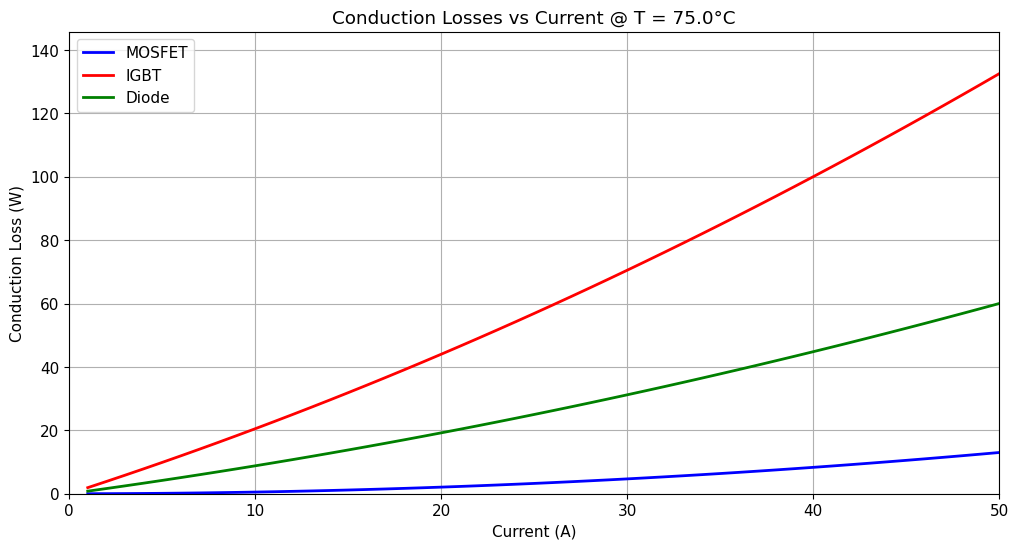

MOSFET is more efficient than IGBT below ~1A


In [14]:
# Cell 8 - Plot conduction losses vs current
I_range = np.linspace(1, 50, 50)
T = 75.0  # 75°C operating temperature

P_mosfet_arr = [ps.ConductionLoss.mosfet(I, mosfet_params, T) for I in I_range]
P_igbt_arr = [ps.ConductionLoss.igbt(I, igbt_params, T) for I in I_range]
P_diode_arr = [ps.ConductionLoss.diode(I, diode_params, T) for I in I_range]

plt.figure(figsize=(12, 6))
plt.plot(I_range, P_mosfet_arr, 'b-', linewidth=2, label='MOSFET')
plt.plot(I_range, P_igbt_arr, 'r-', linewidth=2, label='IGBT')
plt.plot(I_range, P_diode_arr, 'g-', linewidth=2, label='Diode')

plt.xlabel('Current (A)')
plt.ylabel('Conduction Loss (W)')
plt.title(f'Conduction Losses vs Current @ T = {T}°C')
plt.legend()
plt.grid(True)
plt.xlim([0, 50])
plt.ylim([0, max(max(P_mosfet_arr), max(P_igbt_arr), max(P_diode_arr)) * 1.1])
plt.show()

# Find crossover point where MOSFET becomes better than IGBT
for i, I in enumerate(I_range):
    if P_mosfet_arr[i] < P_igbt_arr[i]:
        print(f"MOSFET is more efficient than IGBT below ~{I:.0f}A")
        break

In [15]:
# Cell 10 - Switching loss examples
I_sw = 20.0    # Switching current
V_sw = 48.0    # Switching voltage
T_sw = 75.0    # Junction temperature
f_sw = 100e3   # 100kHz switching frequency

# MOSFET switching losses
E_on_mos = ps.SwitchingLoss.mosfet_Eon(I_sw, V_sw, T_sw, mosfet_params)
E_off_mos = ps.SwitchingLoss.mosfet_Eoff(I_sw, V_sw, T_sw, mosfet_params)
E_total_mos = ps.SwitchingLoss.mosfet_total(I_sw, V_sw, T_sw, mosfet_params)
P_sw_mos = ps.SwitchingLoss.mosfet_power(I_sw, V_sw, T_sw, f_sw, mosfet_params)

# IGBT switching losses
E_on_igbt = ps.SwitchingLoss.igbt_Eon(I_sw, V_sw, T_sw, igbt_params)
E_off_igbt = ps.SwitchingLoss.igbt_Eoff(I_sw, V_sw, T_sw, igbt_params)
E_total_igbt = ps.SwitchingLoss.igbt_total(I_sw, V_sw, T_sw, igbt_params)
P_sw_igbt = ps.SwitchingLoss.igbt_power(I_sw, V_sw, T_sw, f_sw, igbt_params)

print(f"Switching Losses at I={I_sw}A, V={V_sw}V, T={T_sw}°C, f={f_sw/1e3:.0f}kHz:")
print(f"\nMOSFET:")
print(f"  Eon: {E_on_mos * 1e6:.1f} µJ")
print(f"  Eoff: {E_off_mos * 1e6:.1f} µJ")
print(f"  Total: {E_total_mos * 1e6:.1f} µJ/cycle")
print(f"  Power: {P_sw_mos:.2f} W")

print(f"\nIGBT:")
print(f"  Eon: {E_on_igbt * 1e6:.1f} µJ")
print(f"  Eoff: {E_off_igbt * 1e6:.1f} µJ")
print(f"  Total: {E_total_igbt * 1e6:.1f} µJ/cycle")
print(f"  Power: {P_sw_igbt:.2f} W")

Switching Losses at I=20.0A, V=48.0V, T=75.0°C, f=100kHz:

MOSFET:
  Eon: 138.0 µJ
  Eoff: 92.0 µJ
  Total: 230.0 µJ/cycle
  Power: 23.00 W

IGBT:
  Eon: 92.0 µJ
  Eoff: 55.2 µJ
  Total: 147.2 µJ/cycle
  Power: 14.72 W


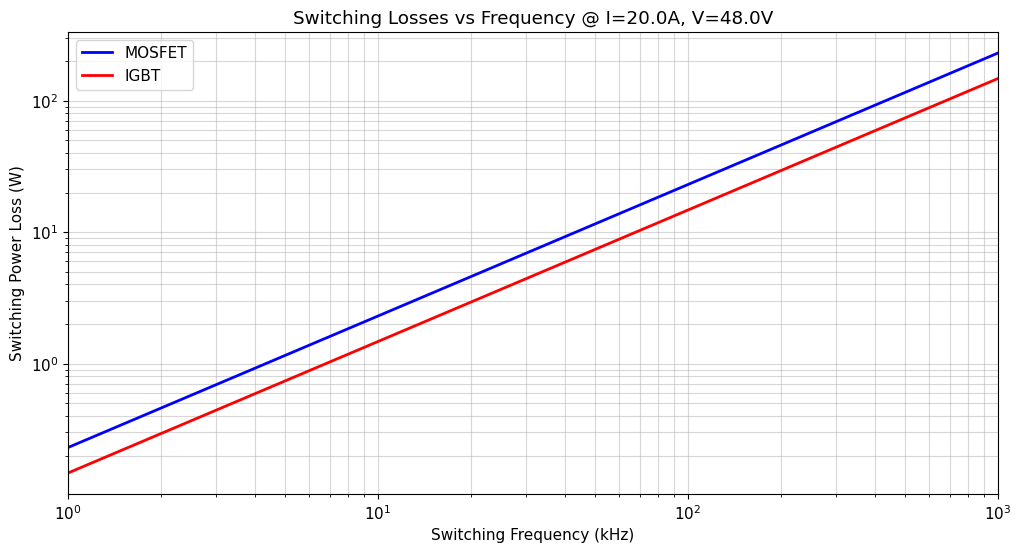

MOSFETs have lower switching losses, enabling higher frequency operation.


In [16]:
# Cell 11 - Switching loss vs frequency
freqs = np.logspace(3, 6, 50)  # 1kHz to 1MHz

P_sw_mos_vs_f = [ps.SwitchingLoss.mosfet_power(I_sw, V_sw, T_sw, f, mosfet_params) for f in freqs]
P_sw_igbt_vs_f = [ps.SwitchingLoss.igbt_power(I_sw, V_sw, T_sw, f, igbt_params) for f in freqs]

plt.figure(figsize=(12, 6))
plt.loglog(freqs / 1e3, P_sw_mos_vs_f, 'b-', linewidth=2, label='MOSFET')
plt.loglog(freqs / 1e3, P_sw_igbt_vs_f, 'r-', linewidth=2, label='IGBT')
plt.xlabel('Switching Frequency (kHz)')
plt.ylabel('Switching Power Loss (W)')
plt.title(f'Switching Losses vs Frequency @ I={I_sw}A, V={V_sw}V')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim([1, 1000])
plt.show()

print("MOSFETs have lower switching losses, enabling higher frequency operation.")

In [17]:
# Cell 13 - Diode reverse recovery losses
I_f = 20.0     # Forward current before turn-off
V_r = 100.0    # Reverse voltage
T_d = 75.0     # Diode temperature
f_d = 100e3    # Switching frequency

# Calculate reverse recovery energy
E_rr = ps.SwitchingLoss.diode_Err(I_f, V_r, T_d, diode_params)
P_rr = ps.SwitchingLoss.diode_power(I_f, V_r, T_d, f_d, diode_params)

print(f"Diode Reverse Recovery at If={I_f}A, Vr={V_r}V:")
print(f"  Qrr: {diode_params.Qrr * 1e9:.0f} nC")
print(f"  Err: {E_rr * 1e6:.1f} µJ per event")
print(f"  Prr @ {f_d/1e3:.0f}kHz: {P_rr:.2f} W")

# Compare standard diode vs fast recovery
fast_diode = ps.DiodeLossParams()
fast_diode.Vf = 1.0        # Higher Vf
fast_diode.Rd = 0.005
fast_diode.Qrr = 30e-9     # Much lower Qrr
fast_diode.trr = 35e-9
fast_diode.Err_factor = 0.5

E_rr_fast = ps.SwitchingLoss.diode_Err(I_f, V_r, T_d, fast_diode)
P_rr_fast = ps.SwitchingLoss.diode_power(I_f, V_r, T_d, f_d, fast_diode)

print(f"\nFast Recovery Diode (Qrr={fast_diode.Qrr*1e9:.0f}nC):")
print(f"  Err: {E_rr_fast * 1e6:.1f} µJ per event")
print(f"  Prr @ {f_d/1e3:.0f}kHz: {P_rr_fast:.2f} W")
print(f"  Savings: {(1 - P_rr_fast/P_rr) * 100:.0f}%")

Diode Reverse Recovery at If=20.0A, Vr=100.0V:
  Qrr: 200 nC
  Err: 10.0 µJ per event
  Prr @ 100kHz: 1.00 W

Fast Recovery Diode (Qrr=30nC):
  Err: 1.5 µJ per event
  Prr @ 100kHz: 0.15 W
  Savings: 85%


In [18]:
# Cell 15 - Buck converter loss analysis
Vin = 48.0     # Input voltage
Vout = 12.0    # Output voltage
Iout = 20.0    # Output current
f_sw = 100e3   # Switching frequency
D = Vout / Vin # Duty cycle

# Operating conditions
T_j = 75.0     # Junction temperature

# High-side MOSFET losses
I_rms_hs = Iout * np.sqrt(D)  # RMS current
P_cond_hs = ps.ConductionLoss.mosfet(I_rms_hs, mosfet_params, T_j)
P_sw_hs = ps.SwitchingLoss.mosfet_power(Iout, Vin, T_j, f_sw, mosfet_params)

# Low-side MOSFET (synchronous rectifier)
I_rms_ls = Iout * np.sqrt(1 - D)  # RMS current
P_cond_ls = ps.ConductionLoss.mosfet(I_rms_ls, mosfet_params, T_j)
P_sw_ls = 0  # ZVS due to body diode conduction

# Alternative: diode rectification
P_cond_diode = ps.ConductionLoss.diode(Iout * (1 - D), diode_params, T_j)
P_rr_diode = ps.SwitchingLoss.diode_power(Iout, Vin, T_j, f_sw, diode_params)

print("Buck Converter Loss Analysis")
print("=" * 50)
print(f"Vin={Vin}V, Vout={Vout}V, Iout={Iout}A, D={D:.2f}")
print(f"fsw={f_sw/1e3:.0f}kHz, Tj={T_j}°C")

print(f"\nHigh-Side MOSFET:")
print(f"  I_rms = {I_rms_hs:.2f} A")
print(f"  Conduction: {P_cond_hs:.2f} W")
print(f"  Switching: {P_sw_hs:.2f} W")
print(f"  Total: {P_cond_hs + P_sw_hs:.2f} W")

print(f"\nLow-Side (Sync FET):")
print(f"  I_rms = {I_rms_ls:.2f} A")
print(f"  Conduction: {P_cond_ls:.2f} W")
print(f"  Switching: {P_sw_ls:.2f} W (ZVS)")
print(f"  Total: {P_cond_ls + P_sw_ls:.2f} W")

print(f"\nLow-Side (Diode):")
print(f"  Conduction: {P_cond_diode:.2f} W")
print(f"  Rev Recovery: {P_rr_diode:.2f} W")
print(f"  Total: {P_cond_diode + P_rr_diode:.2f} W")

Buck Converter Loss Analysis
Vin=48.0V, Vout=12.0V, Iout=20.0A, D=0.25
fsw=100kHz, Tj=75.0°C

High-Side MOSFET:
  I_rms = 10.00 A
  Conduction: 0.52 W
  Switching: 23.00 W
  Total: 23.52 W

Low-Side (Sync FET):
  I_rms = 17.32 A
  Conduction: 1.56 W
  Switching: 0.00 W (ZVS)
  Total: 1.56 W

Low-Side (Diode):
  Conduction: 13.80 W
  Rev Recovery: 0.48 W
  Total: 14.28 W


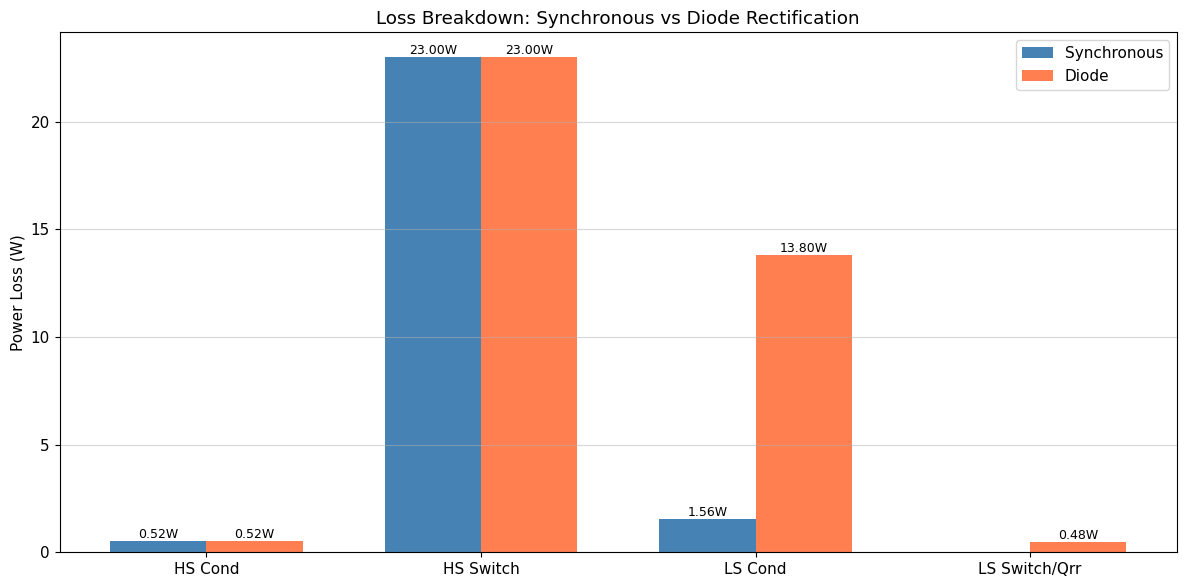


Total Losses:
  Synchronous: 25.08 W
  Diode: 37.80 W


In [19]:
# Cell 16 - Visualize loss breakdown
components = ['HS Cond', 'HS Switch', 'LS Cond', 'LS Switch/Qrr']

losses_sync = [P_cond_hs, P_sw_hs, P_cond_ls, P_sw_ls]
losses_diode = [P_cond_hs, P_sw_hs, P_cond_diode, P_rr_diode]

x = np.arange(len(components))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, losses_sync, width, label='Synchronous', color='steelblue')
bars2 = ax.bar(x + width/2, losses_diode, width, label='Diode', color='coral')

ax.set_ylabel('Power Loss (W)')
ax.set_title('Loss Breakdown: Synchronous vs Diode Rectification')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()
ax.grid(True, axis='y', alpha=0.5)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    if height > 0.01:
        ax.annotate(f'{height:.2f}W',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    if height > 0.01:
        ax.annotate(f'{height:.2f}W',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Calculate efficiencies
P_out = Vout * Iout
P_loss_sync = sum(losses_sync)
P_loss_diode = sum(losses_diode)

print(f"\nTotal Losses:")
print(f"  Synchronous: {P_loss_sync:.2f} W")
print(f"  Diode: {P_loss_diode:.2f} W")

In [20]:
# Cell 18 - Efficiency calculation using EfficiencyCalculator
P_out = Vout * Iout  # Output power

# Calculate efficiency from losses
eff_sync = ps.EfficiencyCalculator.from_losses(P_out, P_loss_sync)
eff_diode = ps.EfficiencyCalculator.from_losses(P_out, P_loss_diode)

print(f"Efficiency Analysis:")
print(f"  Output Power: {P_out:.1f} W")
print(f"\n  Synchronous rectification:")
print(f"    Losses: {P_loss_sync:.2f} W")
print(f"    Efficiency: {eff_sync * 100:.2f}%")
print(f"\n  Diode rectification:")
print(f"    Losses: {P_loss_diode:.2f} W")
print(f"    Efficiency: {eff_diode * 100:.2f}%")

# Calculate input power
P_in_sync = ps.EfficiencyCalculator.input_power(eff_sync, P_out)
P_in_diode = ps.EfficiencyCalculator.input_power(eff_diode, P_out)

print(f"\n  Input power (sync): {P_in_sync:.1f} W")
print(f"  Input power (diode): {P_in_diode:.1f} W")

Efficiency Analysis:
  Output Power: 240.0 W

  Synchronous rectification:
    Losses: 25.08 W
    Efficiency: 90.54%

  Diode rectification:
    Losses: 37.80 W
    Efficiency: 86.39%

  Input power (sync): 265.1 W
  Input power (diode): 277.8 W


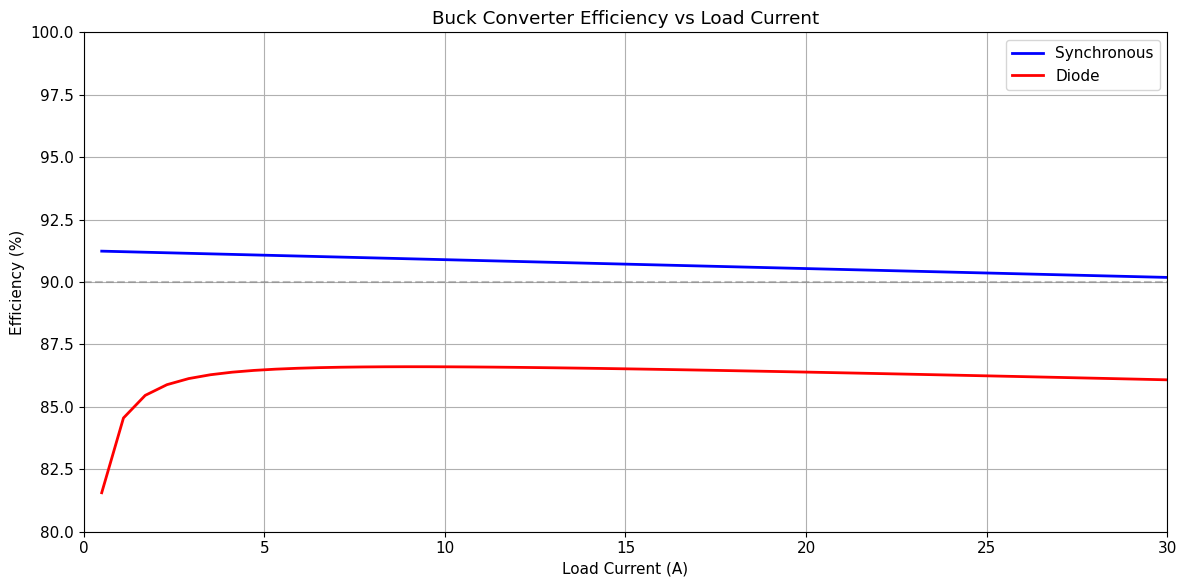

Synchronous rectification provides higher efficiency,
especially at high currents where I²R losses dominate.


In [21]:
# Cell 19 - Efficiency vs load current
I_loads = np.linspace(0.5, 30, 50)

eff_sync_arr = []
eff_diode_arr = []

for I in I_loads:
    # High-side losses
    I_rms = I * np.sqrt(D)
    P_cond_h = ps.ConductionLoss.mosfet(I_rms, mosfet_params, T_j)
    P_sw_h = ps.SwitchingLoss.mosfet_power(I, Vin, T_j, f_sw, mosfet_params)
    
    # Low-side sync
    I_rms_l = I * np.sqrt(1 - D)
    P_cond_l = ps.ConductionLoss.mosfet(I_rms_l, mosfet_params, T_j)
    
    # Low-side diode
    P_cond_d = ps.ConductionLoss.diode(I * (1 - D), diode_params, T_j)
    P_rr_d = ps.SwitchingLoss.diode_power(I, Vin, T_j, f_sw, diode_params)
    
    P_out_i = Vout * I
    P_loss_s = P_cond_h + P_sw_h + P_cond_l
    P_loss_d = P_cond_h + P_sw_h + P_cond_d + P_rr_d
    
    eff_sync_arr.append(ps.EfficiencyCalculator.from_losses(P_out_i, P_loss_s) * 100)
    eff_diode_arr.append(ps.EfficiencyCalculator.from_losses(P_out_i, P_loss_d) * 100)

plt.figure(figsize=(12, 6))
plt.plot(I_loads, eff_sync_arr, 'b-', linewidth=2, label='Synchronous')
plt.plot(I_loads, eff_diode_arr, 'r-', linewidth=2, label='Diode')
plt.axhline(y=90, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Load Current (A)')
plt.ylabel('Efficiency (%)')
plt.title('Buck Converter Efficiency vs Load Current')
plt.legend()
plt.grid(True)
plt.ylim([80, 100])
plt.xlim([0, 30])
plt.tight_layout()
plt.show()

print("Synchronous rectification provides higher efficiency,")
print("especially at high currents where I²R losses dominate.")

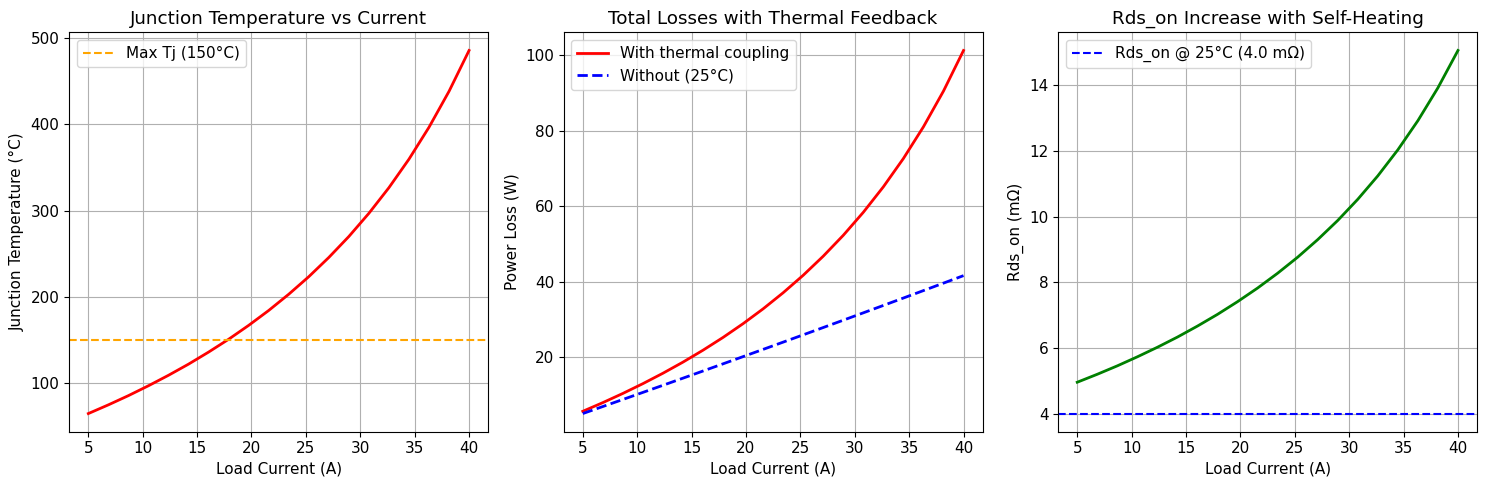

Thermal coupling increases losses above the cold (25°C) calculation!


In [22]:
# Cell 21 - Thermal-electrical coupling analysis
# Create thermal model for the MOSFET
R_th = [0.3, 0.5, 0.8, 1.0]  # K/W (junction to case stages)
tau = [0.5e-3, 5e-3, 50e-3, 200e-3]  # Time constants
thermal_network = ps.FosterNetwork(R_th, tau, "MOSFET_JC")

Rth_cs = 0.3      # Case-sink
Rth_sa = 1.5      # Sink-ambient
Rth_total = thermal_network.total_Rth() + Rth_cs + Rth_sa

T_ambient = 40.0  # 40°C ambient

def solve_thermal_equilibrium(I_load, mosfet_p, Rth, T_amb):
    """Iteratively solve for steady-state junction temperature."""
    T_j = T_amb  # Initial guess
    
    for _ in range(20):
        # Calculate losses at current temperature
        I_rms = I_load * np.sqrt(D)
        P_cond = ps.ConductionLoss.mosfet(I_rms, mosfet_p, T_j)
        P_sw = ps.SwitchingLoss.mosfet_power(I_load, Vin, T_j, f_sw, mosfet_p)
        P_total = P_cond + P_sw
        
        # New junction temperature
        T_j_new = T_amb + P_total * Rth
        
        if abs(T_j_new - T_j) < 0.1:
            break
        T_j = T_j_new
    
    return T_j, P_cond, P_sw

# Analyze for different currents
I_range = np.linspace(5, 40, 20)
T_j_arr = []
P_cond_arr = []
P_sw_arr = []
P_total_arr = []

# Also calculate without thermal coupling (at fixed 25°C)
P_cond_cold = []
P_sw_cold = []

for I in I_range:
    T_j, P_c, P_s = solve_thermal_equilibrium(I, mosfet_params, Rth_total, T_ambient)
    T_j_arr.append(T_j)
    P_cond_arr.append(P_c)
    P_sw_arr.append(P_s)
    P_total_arr.append(P_c + P_s)
    
    # Cold calculation
    I_rms = I * np.sqrt(D)
    P_cond_cold.append(ps.ConductionLoss.mosfet(I_rms, mosfet_params, 25.0))
    P_sw_cold.append(ps.SwitchingLoss.mosfet_power(I, Vin, 25.0, f_sw, mosfet_params))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Junction temperature
axes[0].plot(I_range, T_j_arr, 'r-', linewidth=2)
axes[0].axhline(y=150, color='orange', linestyle='--', label='Max Tj (150°C)')
axes[0].set_xlabel('Load Current (A)')
axes[0].set_ylabel('Junction Temperature (°C)')
axes[0].set_title('Junction Temperature vs Current')
axes[0].legend()
axes[0].grid(True)

# Loss comparison
axes[1].plot(I_range, P_total_arr, 'r-', linewidth=2, label='With thermal coupling')
P_total_cold = [P_cond_cold[i] + P_sw_cold[i] for i in range(len(I_range))]
axes[1].plot(I_range, P_total_cold, 'b--', linewidth=2, label='Without (25°C)')
axes[1].set_xlabel('Load Current (A)')
axes[1].set_ylabel('Power Loss (W)')
axes[1].set_title('Total Losses with Thermal Feedback')
axes[1].legend()
axes[1].grid(True)

# Rds_on increase
Rds_vs_T = [mosfet_params.Rds_on_at_T(T) * 1000 for T in T_j_arr]
axes[2].plot(I_range, Rds_vs_T, 'g-', linewidth=2)
axes[2].axhline(y=mosfet_params.Rds_on * 1000, color='b', linestyle='--', 
                label=f'Rds_on @ 25°C ({mosfet_params.Rds_on * 1000:.1f} mΩ)')
axes[2].set_xlabel('Load Current (A)')
axes[2].set_ylabel('Rds_on (mΩ)')
axes[2].set_title('Rds_on Increase with Self-Heating')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("Thermal coupling increases losses above the cold (25°C) calculation!")